# 2. Entendimiento y Preparacion de los datos


## 2.0 Carga de Datos y Librerias

En este momento vamos a cargar los datos planos del archivo fake_news_spanish.csv para utilizarlo así como importar las librerias necesarias para el resto del notebook.

In [75]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import spacy

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import re, string, unicodedata
import contractions
import inflect

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download('punkt_tab')

import scipy.stats as stats

from collections import Counter

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

db_location = 'fake_news_spanish.csv'

news_df=pd.read_csv(db_location, sep=';', encoding = "UTF-8") 

news_df = news_df.astype(str)

news_df.head()

[nltk_data] Downloading package punkt_tab to C:\Users\HP
[nltk_data]     Pavilion\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018



## 2.1 Entendimiento de datos
Para entender los datos procedemos a ver su estructura:


In [76]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  object
 2   Titulo       57063 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: object(5)
memory usage: 2.2+ MB


Como podemos ver tenemos 5 columnas y 57 mil filas. De estas las mas importantes son las de "Label", "Titulo" y "Descripcion". Pues de estas vamos a obtener todas las variables para nuestro modelo de clasificación.

### Estadísticas descriptivas

Para entender las noticias vamos a realizar estadísticas descriptivas de los textos.

In [77]:
textos = news_df.copy()

textos['Conteo'] = [len(str(x)) for x in textos['Titulo']]
textos['Moda'] = [Counter([word.lower().strip(string.punctuation) for word in (str(i).split(' '))]).most_common()[0][0] for i in textos['Titulo']]
textos['Max'] = [[max([len(x) for x in str(i).split(' ')])][0] for i in textos['Titulo']]
textos['Min'] = [[min([len(x) for x in str(i).split(' ')])][0] for i in textos['Titulo']]

textos.head()

,ID,Label,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,77,the,9,2
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,104,el,10,1
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,77,el,10,1
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,110,a,12,1
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,72,puigdemont,11,2


In [78]:
# from ydata_profiling import ProfileReport

# # Assuming 'textos' is your DataFrame
# profile = ProfileReport(textos, explorative=True)

# # Display the report in the notebook
# profile.to_notebook_iframe()

In [79]:
news_df = news_df[["Label", "Titulo", "Descripcion"]]

## 2.2 Preparacion de datos

Para preparar los datos vamos a seguir los pasos de procesamiento de texto tanto para el titúlo asi como las descripciones.

### 2.2.1 Eliminación de Ruido

Para eliminar el ruido vamos a eliminar cualquier instancia de caracter especial ($, @, ..., etc) y/o caracter de separacion (',', '.', ..., etc). Tambien vamos a estandarizar los caracteres para que todos se encuentren en minusculas.


In [80]:
def processWords(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    stop_words_set = set(stopwords.words('spanish'))
    for word in words:
        if word is not None:
            new_word = word.lower()
            if new_word not in stop_words_set:
                new_word = unicodedata.normalize('NFKD', new_word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
                
                new_word = re.sub(r'[^\w\s]', '', new_word)
                if new_word != '':
                    new_words.append(new_word)
    return new_words

def preprocessing(words):
    words = processWords(words)
    return words




### 2.2.2 Tokenización 

Se va a tokenizar cada palabra para que se pueda ingresar en una lista de tokens

In [81]:
news_df['TituloTok'] = news_df['Titulo'].apply(word_tokenize)
news_df['DescripTok'] = news_df['Descripcion'].apply(word_tokenize)


In [82]:
news_df['TituloLimpio']=news_df['TituloTok'].apply(preprocessing)
news_df['DescripcionLimpio']=news_df['DescripTok'].apply(preprocessing)

news_df.head()


,Label,Titulo,Descripcion,TituloTok,DescripTok,TituloLimpio,DescripcionLimpio
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,"['The, Guardian, ', va, con, Sánchez, :, 'Euro...","[El, diario, británico, publicó, este, pasado,...","[the, guardian, va, sanchez, europa, necesita,...","[diario, britanico, publico, pasado, jueves, e..."
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[revelan, gobierno, negocio, liberacion, mirel...","[revelan, gobierno, negocio, liberacion, mirel..."
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,"[El, 'Ahora, o, nunca, ', de, Joan, Fuster, so...","[El, valencianismo, convoca, en, Castelló, su,...","[ahora, nunca, joan, fuster, estatuto, valenci...","[valencianismo, convoca, castello, fiesta, gra..."
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...","[Iglesias, alienta, a, Yolanda, Díaz, ,, ERC, ...","[En, política, ,, igual, que, hay, que, negoci...","[iglesias, alienta, yolanda, diaz, erc, eh, bi...","[politica, igual, negociar, empresarios, negoc..."
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...","[Puigdemont, :, 'No, sería, ninguna, tragedia,...","[En, una, entrevista, en, El, Punt, Avui, ,, e...","[puigdemont, no, ninguna, tragedia, repeticion...","[entrevista, punt, avui, lider, jxcat, desdram..."


In [83]:
news_df = news_df[["Label", "TituloLimpio", "DescripcionLimpio"]]
news_df.head()

,Label,TituloLimpio,DescripcionLimpio
0,1,"[the, guardian, va, sanchez, europa, necesita,...","[diario, britanico, publico, pasado, jueves, e..."
1,0,"[revelan, gobierno, negocio, liberacion, mirel...","[revelan, gobierno, negocio, liberacion, mirel..."
2,1,"[ahora, nunca, joan, fuster, estatuto, valenci...","[valencianismo, convoca, castello, fiesta, gra..."
3,1,"[iglesias, alienta, yolanda, diaz, erc, eh, bi...","[politica, igual, negociar, empresarios, negoc..."
4,0,"[puigdemont, no, ninguna, tragedia, repeticion...","[entrevista, punt, avui, lider, jxcat, desdram..."


### 2.2.3 Lematización

Ahora vamos a lematizar las palabras, o de otra forma vamos a aplanar el lenguaje de las mismas (Corrió -> Correr)

In [ ]:
nlp = spacy.load("es_core_news_sm")

def lemmaWords(words):
    new_words = ""
    for word in words:
        new_words += word + " "
    return new_words

news_df['TituloLemm']=news_df['TituloLimpio'].apply(lemmaWords)
news_df['DescripcionLemm']=news_df['DescripcionLimpio'].apply(lemmaWords)



In [85]:
news_df.head()

,Label,TituloLimpio,DescripcionLimpio,TituloLemm,DescripcionLemm
0,1,"[the, guardian, va, sanchez, europa, necesita,...","[diario, britanico, publico, pasado, jueves, e...",the guardian va sanchez europa necesita apuest...,diario britanico publico pasado jueves editori...
1,0,"[revelan, gobierno, negocio, liberacion, mirel...","[revelan, gobierno, negocio, liberacion, mirel...",revelan gobierno negocio liberacion mireles ca...,revelan gobierno negocio liberacion mireles ca...
2,1,"[ahora, nunca, joan, fuster, estatuto, valenci...","[valencianismo, convoca, castello, fiesta, gra...",ahora nunca joan fuster estatuto valenciano cu...,valencianismo convoca castello fiesta grande c...
3,1,"[iglesias, alienta, yolanda, diaz, erc, eh, bi...","[politica, igual, negociar, empresarios, negoc...",iglesias alienta yolanda diaz erc eh bildu neg...,politica igual negociar empresarios negociar g...
4,0,"[puigdemont, no, ninguna, tragedia, repeticion...","[entrevista, punt, avui, lider, jxcat, desdram...",puigdemont no ninguna tragedia repeticion elec...,entrevista punt avui lider jxcat desdramatizad...


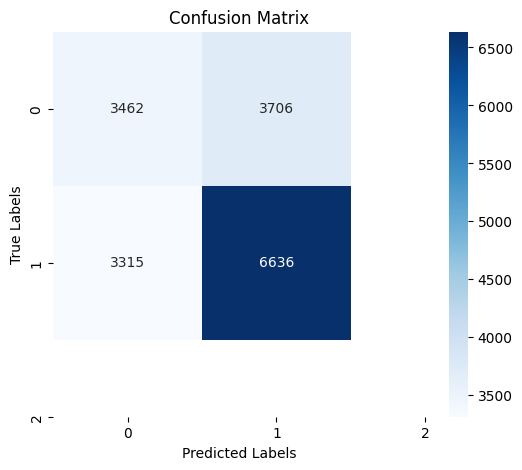

In [ ]:
 # Se selecciona la variable objetivo, en este caso "Label".
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text data into numerical vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(news_df['TituloLemm'])  # Convert text into TF-IDF features


Y = news_df['Label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh = neigh.fit(X_train, Y_train)

y_pred = neigh.predict(X_test)

cm = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [93]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print(classification_report(Y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.51      0.48      0.50      7168
           1       0.64      0.67      0.65      9951

    accuracy                           0.59     17119
   macro avg       0.58      0.57      0.58     17119
weighted avg       0.59      0.59      0.59     17119

